In [1]:
import numpy as np
import tensorflow as tf

import os

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Load data from full simulations

In [2]:
def load_multiple_records(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    records = []
    current_record = []
    header = lines[0].strip()  # Assuming the first line is the header
    
    for line in lines:
        if line.strip() == header:
            if current_record:
                records.append(np.array(current_record, dtype=float))
                current_record = []
        else:
            current_record.append([float(value) for value in line.split()])
    
    if current_record:  # Add the last record if the file doesn't end with a header line
        records.append(np.array(current_record, dtype=float))
    
    return records

In [3]:
# Folder path where the files are stored
folder_path = r'C:\Users\joses\Mi unidad\TRABAJO\48_FG_protection\TRABAJO\fgp_optimizer\optimization_simple_plastic\full_simulation_data\iter0'
# folder_path = r'C:\Users\joses\Mi unidad\TRABAJO\48_FG_protection\TRABAJO\fgp_optimizer\optimization_simple_plastic\full_simulation_data\iter0_1nodo'

# Dictionary to store the data for each node
data_dicts = {}
node_ids = []
nodes = np.loadtxt(os.path.join(folder_path, 'nodos.txt'))[:, 1:]

# Iterate over each file in the folder
for filename in os.listdir(folder_path):
    if filename.startswith('presion_node'):
        # Extract the node ID from the filename
        node_id = filename.split(' ')[-1]
        node_ids.append(node_id)
        
        # Construct the full file path
        file_path = os.path.join(folder_path, filename)
        
        # Load the data, skipping the first line
        data = load_multiple_records(file_path)
        
        # Store the time and pressure data in the dictionary under the node_id
        data_dicts[node_id] = {
            'time': data[0][:, 0],
            'pressure': -np.mean(np.array(data), axis=0)[:,1],
            'displacement': np.loadtxt(file_path.replace('presion_node ', 'flecha_node'), skiprows=1)[:, 1], 
            'coordinates': nodes[int(node_id)]
        }


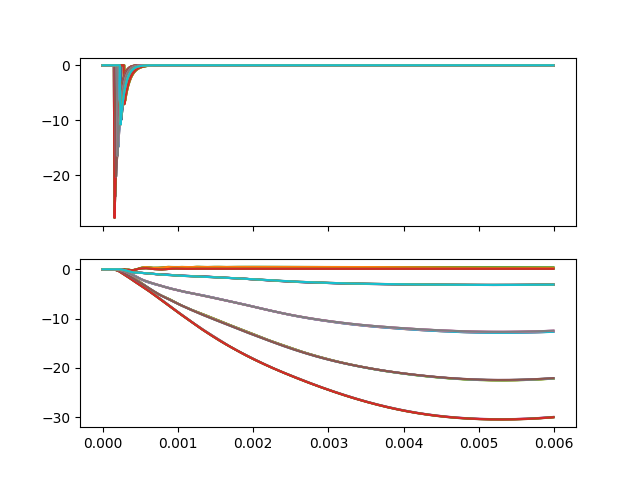

In [48]:
fig, ax = plt.subplots(2, 1, sharex='col')
ax = ax.flatten()

n_rows = 600
for node_id in node_ids:
    ax[0].plot(data_dicts[node_id]['time'][:n_rows], data_dicts[node_id]['pressure'][:n_rows])
    ax[1].plot(data_dicts[node_id]['time'][:n_rows], data_dicts[node_id]['displacement'][:n_rows])

plt.show()


C:\Users\joses\AppData\Local\Temp\ipykernel_15000\2296854808.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


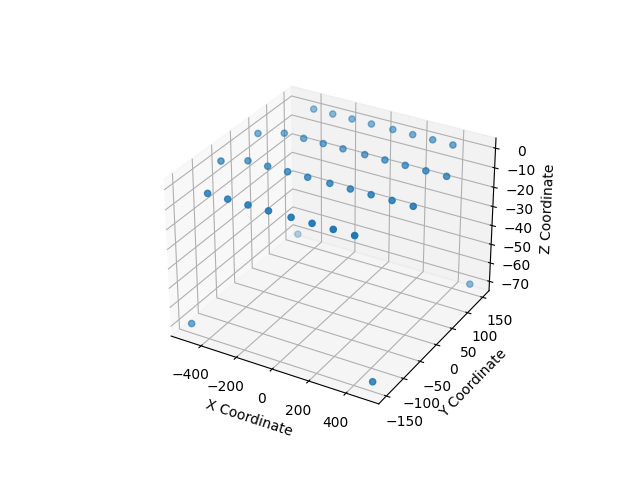

In [49]:
coordinates = np.array([data_dicts[node_id]['coordinates'] for node_id in node_ids])

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2])

# Set labels (optional)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')

plt.show()

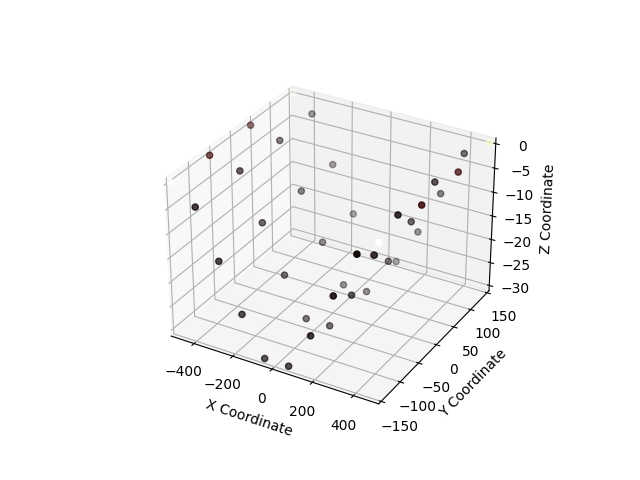

In [50]:
stride = 10

# Assuming data_dicts and node_ids are already defined
coordinates = np.array([data_dicts[node_id]['coordinates'] for node_id in node_ids])
displacement_data = np.array([data_dicts[node_id]['displacement'][:n_rows] for node_id in node_ids])
pressure_data = np.array([data_dicts[node_id]['pressure'][:n_rows] for node_id in node_ids])
time_data = np.array(data_dicts[node_ids[0]]['time'][:n_rows])

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Initialize scatter plot
scat = ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2])

# Set labels (optional)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')

# Function to update the scatter plot
def update(frame):
    ax.clear()
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')
    ax.set_xlim([coordinates[:, 0].min(), coordinates[:, 0].max()])
    ax.set_ylim([coordinates[:, 1].min(), coordinates[:, 1].max()])
    ax.set_zlim([displacement_data.min(), displacement_data.max()])
    ax.scatter(coordinates[:, 0], coordinates[:, 1], displacement_data[:, frame], c=pressure_data[:, frame], cmap='hot')
    return scat,

# Create the animation
ani = FuncAnimation(fig, update, frames=range(0, len(displacement_data[0]), stride), interval=1000/25, blit=False)

HTML(ani.to_jshtml())


In [51]:
print(f'{time_data.shape=}')

time_data.shape=(600,)


In [52]:
print(f'{displacement_data.shape=}')

displacement_data.shape=(40, 600)


In [53]:
print(f'{pressure_data.shape=}')

pressure_data.shape=(40, 600)


# Definition of the surrogate model

In [80]:
class SDOFDynamicsLayer(tf.keras.layers.Layer):
  def __init__(self, delta_t, n):
    super(SDOFDynamicsLayer, self).__init__()
    self.delta_t = delta_t
    self.n = n
  
    # Trainable parameters: ms, ks, cs
    self._ms = tf.Variable(1.0, dtype=tf.float32, trainable=True, name="raw_mass")
    self._ks = tf.Variable(1.0, dtype=tf.float32, trainable=True, name="raw_stiffness")
    self._cs = tf.Variable(0.1, dtype=tf.float32, trainable=True, name="raw_damping")

  @property
  def ms(self):
    return self._ms ** 2
    # return tf.nn.softplus(self._ms)  # Ensure positive mass

  @property
  def ks(self):
    return self._ks ** 2
    # return tf.nn.softplus(self._ks)  # Ensure positive stiffness

  @property
  def cs(self):
    return self._cs ** 2
    # return tf.nn.softplus(self._cs)  # Ensure positive damping

  def call(self, inputs):
    state_k, f_k = inputs  # Unpack the input tensor

    # Define matrices A and B for the discrete-time system
    A_d = tf.stack([[1.0, self.delta_t],
                    [-(self.ks / self.ms) * self.delta_t, 1.0 - (self.cs / self.ms) * self.delta_t]], axis=0)

    B_d = tf.stack([[0.0], 
                    [self.delta_t / self.ms]], axis=0)

    # Expand dims of A_d and B_d to match the batch size (broadcasting to batch size)
    A_d = tf.expand_dims(A_d, axis=0)  
    B_d = tf.expand_dims(B_d, axis=0) 
    
    # Compute next state at time k+1
    state_k_plus_1_dyn = tf.matmul(A_d, state_k)  # A_d [batch_size, 2, 2], state_k [batch_size, 2, 1]
    state_k_plus_1_ind = tf.matmul(B_d, f_k)  # B_d [batch_size, 2, 1], f_k [batch_size, 1]
    state_k_plus_1 = state_k_plus_1_dyn + state_k_plus_1_ind

    # Remove extra dimension for easier slicing
    state_k_plus_1 = tf.squeeze(state_k_plus_1, axis=-1)  # Shape [batch_size, 2]
    
    return state_k_plus_1


# # Custom constraint to ensure the largest absolute value of the weights is 1
# class MaxAbsConstraint(tf.keras.constraints.Constraint):
#     def __call__(self, weights):
#         max_abs_value = tf.reduce_max(tf.abs(weights))
#         return weights / max_abs_value

# Custom constraint to ensure the largest absolute value of the weights is 1
class MaxAbsConstraint(tf.keras.constraints.Constraint):
    def __call__(self, weights):
        return weights  
    
# Custom call back for sharing weights
class WeightSharingCallback(tf.keras.callbacks.Callback):
    def on_batch_end(self, batch, logs=None):
        scalar2vector_weights = self.model.get_layer('scalar2vector_x').get_weights()[0]
        vector2scalar_weights = self.model.get_layer('vector2scalar_x').get_weights()[0]
        transposed_scalar2vector_weights = tf.transpose(scalar2vector_weights)
        
        # Ensure the weights are symmetric
        symmetric_weights = (vector2scalar_weights + transposed_scalar2vector_weights) / 2
        
        # Normalize the symmetric weights to ensure the dot product is 1
        norm = tf.norm(symmetric_weights)
        normalized_weights = symmetric_weights / norm
        
        self.model.get_layer('vector2scalar_x').set_weights([normalized_weights])
        self.model.get_layer('scalar2vector_x').set_weights([tf.transpose(normalized_weights)])


def create_sdof_model(delta_t, n, linear_projection: bool = True, 
                      vector2scalar_f_const: bool = True, 
                      vector2scalar_x_const: bool = False, 
                      scalar2vector_x_const: bool = False):
    # Define the input layers
    xr_input = tf.keras.Input(shape=(n,), name='xr_input')  # Displacement input
    xrdot_input = tf.keras.Input(shape=(n,), name='xrdot_input')  # Velocity input
    fr_input = tf.keras.Input(shape=(n,), name='fr_input')  # Force input

    # Linear projection layers
    if linear_projection:
        if vector2scalar_f_const:
            vector2scalar_f = tf.keras.layers.Dense(1, activation='linear', use_bias=False, 
                                                    kernel_constraint=MaxAbsConstraint(), kernel_initializer='ones',
                                                    name='vector2scalar_f', trainable=False)
        else:
            vector2scalar_f = tf.keras.layers.Dense(1, activation='linear', use_bias=False, 
                                                    kernel_constraint=MaxAbsConstraint(), kernel_initializer='ones',
                                                    name='vector2scalar_f', trainable=True)
        if vector2scalar_x_const:
            vector2scalar_x = tf.keras.layers.Dense(1, activation='linear', use_bias=False, 
                                                    kernel_constraint=MaxAbsConstraint(), kernel_initializer='ones',
                                                    name='vector2scalar_x', trainable=False)
        else:
            vector2scalar_x = tf.keras.layers.Dense(1, activation='linear', use_bias=False, 
                                                    kernel_constraint=MaxAbsConstraint(), kernel_initializer='ones',
                                                    name='vector2scalar_x', trainable=True)
        if scalar2vector_x_const:
           scalar2vector_x = tf.keras.layers.Dense(n, activation='linear', use_bias=False, 
                                                   kernel_constraint=MaxAbsConstraint(), kernel_initializer='ones',
                                                   name='scalar2vector_x', trainable=False)
        else:
           scalar2vector_x = tf.keras.layers.Dense(n, activation='linear', use_bias=False, 
                                                   kernel_constraint=MaxAbsConstraint(), kernel_initializer='ones',
                                                   name='scalar2vector_x', trainable=True)
    else:
        raise NotImplementedError("Non-linear projection is not implemented.")

    # Transform vectors into scalars
    x_k = vector2scalar_x(xr_input)  

    xdot_k = vector2scalar_x(xrdot_input)

    # Add an extra dimension to match the required input shape
    x_k = tf.expand_dims(x_k, axis=-1)  # Shape [batch_size, 1, 1]
    xdot_k = tf.expand_dims(xdot_k, axis=-1)  # Shape [batch_size, 1, 1]

    state_k = tf.concat([x_k, xdot_k], axis=1)  # Shape [batch_size, 2, 1]

    # Process force input similarly
    f_k = vector2scalar_f(fr_input)
    f_k = tf.expand_dims(f_k, axis=-1)  # Shape [batch_size, 1]

    # Create SDOF dynamics layer
    dynamics_layer = SDOFDynamicsLayer(delta_t, n)
    state_k_plus_1 = dynamics_layer((state_k, f_k))

    # Extract new state variables
    x_k_plus_1 = state_k_plus_1[:, 0]  # Shape [batch_size]
    xdot_k_plus_1 = state_k_plus_1[:, 1]  # Shape [batch_size]

    # Ensure that x_k_plus_1 and xdot_k_plus_1 have at least two dimensions
    x_k_plus_1 = tf.expand_dims(x_k_plus_1, axis=-1)  # Shape [batch_size, 1]
    xdot_k_plus_1 = tf.expand_dims(xdot_k_plus_1, axis=-1)  # Shape [batch_size, 1]

    # Transform scalars back into vectors
    xr_k_plus_1 = scalar2vector_x(x_k_plus_1)
    xrdot_k_plus_1 = scalar2vector_x(xdot_k_plus_1)

    # Create a model
    model = tf.keras.Model(inputs=[xr_input, xrdot_input, fr_input], outputs=[xr_k_plus_1, xrdot_k_plus_1])

    return model


In [81]:
# Example usage
delta_t = np.round(np.mean(np.diff(time_data)), 5)
n = displacement_data.shape[0]  # Example dimension
sdof_model = create_sdof_model(delta_t, n)
sdof_model.summary()  # Print the model summary


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 xr_input (InputLayer)       [(None, 40)]                 0         []                            
                                                                                                  
 xrdot_input (InputLayer)    [(None, 40)]                 0         []                            
                                                                                                  
 vector2scalar_x (Dense)     (None, 1)                    40        ['xr_input[0][0]',            
                                                                     'xrdot_input[0][0]']         
                                                                                                  
 fr_input (InputLayer)       [(None, 40)]                 0         []                      

# Train set generation from time history dataset

## Resampling to a constant delta_t

In [82]:
from scipy.interpolate import interp1d


# New time vector
time_resampled = np.arange(time_data[0], time_data[-1], delta_t)

# Create an interpolation function
interp_disp_func = interp1d(time_data, displacement_data, kind='linear', fill_value="extrapolate")
interp_pres_func = interp1d(time_data, pressure_data, kind='linear', fill_value="extrapolate")


# Resample values using the interpolation function
displacement_resampled = interp_disp_func(time_resampled)
pressure_resampled = interp_pres_func(time_resampled)

print(f'{time_resampled.shape=}')

time_resampled.shape=(599,)


## Velocity estimation

In [83]:
velocity_resampled = np.diff(displacement_resampled, prepend=0)/delta_t

### Plots for inspecting resampling

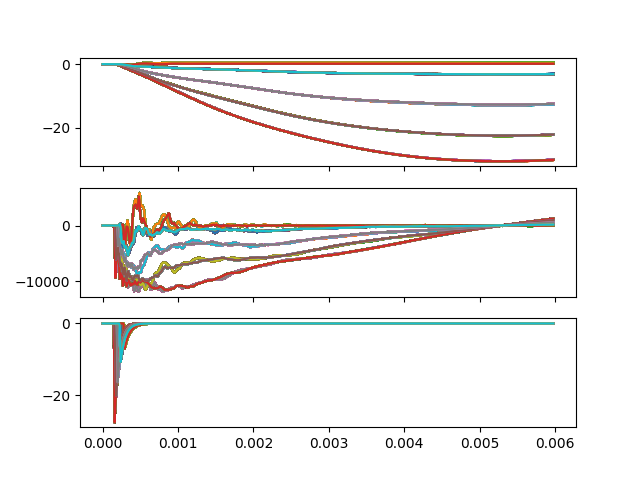

In [84]:
fig, ax = plt.subplots(3, 1, sharex='col')
ax = ax.flatten()


for node_id in node_ids:
    ax[0].plot(time_resampled, displacement_resampled.T)
    ax[1].plot(time_resampled, velocity_resampled.T)
    ax[2].plot(time_resampled, pressure_resampled.T)

plt.show()

## X and Y

In [85]:
X1 = displacement_resampled.T[:-1, :]
X2 = velocity_resampled.T[:-1, :]
X3 = pressure_resampled.T[:-1, :]

Y1 = displacement_resampled.T[1:, :]
Y2 = velocity_resampled.T[1:, :]

## Scaling

In [86]:
from sklearn.preprocessing import MinMaxScaler


scale_X1 = np.max(np.abs(X1))
scale_X2 = np.max(np.abs(X2))
scale_X3 = np.max(np.abs(X3))
scale_Y1 = np.max(np.abs(Y1))
scale_Y2 = np.max(np.abs(Y2))

X1_norm = X1 / scale_X1
X2_norm = X2 / scale_X2
X3_norm = X3 / scale_X3
Y1_norm = Y1 / scale_Y1
Y2_norm = Y2 / scale_Y2

## Train Test Split

In [87]:
from sklearn.model_selection import train_test_split


# Split the datasets into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    np.hstack([X1_norm, X2_norm, X3_norm]),  # Combine inputs into a single array and transpose
    np.hstack([Y1_norm, Y2_norm]),  # Combine outputs into a single array and transpose
    test_size=0.1,  # % of the data will be used for testing
    random_state=42,  # Optional: set a seed for reproducibility
    shuffle=True
)

# Now we have training and testing datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (538, 120)
X_test shape: (60, 120)
Y_train shape: (538, 80)
Y_test shape: (60, 80)


# Compile and Fit the model

In [109]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)

callbacks=[WeightSharingCallback(), reduce_lr]
# callbacks=[reduce_lr]

delta_t_model = 1.0
sdof_model = create_sdof_model(delta_t_model, n)

sdof_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error', loss_weights=[1.0, 0.1])

# epochs
epochs = 50
batch_size = 128

# Fit the model and capture the history
history = sdof_model.fit([X_train[:, :n], X_train[:, n:2*n], X_train[:, 2*n:]], [Y_train[:, :n], Y_train[:, n:2*n]], 
               validation_data=[[X_test[:, :n], X_test[:, n:2*n], X_test[:, 2*n:]], [Y_test[:, :n], Y_test[:, n:2*n]]],
               batch_size=batch_size, epochs=epochs, callbacks=callbacks)



Epoch 1/50
5/5 [==============================] - 2s 140ms/step - loss: 98.3139 - scalar2vector_x_loss: 94.7379 - scalar2vector_x_1_loss: 35.7596 - val_loss: 0.1904 - val_scalar2vector_x_loss: 0.1769 - val_scalar2vector_x_1_loss: 0.1343 - lr: 0.1000
Epoch 2/50
5/5 [==============================] - 0s 22ms/step - loss: 0.2096 - scalar2vector_x_loss: 0.1987 - scalar2vector_x_1_loss: 0.1095 - val_loss: 0.1742 - val_scalar2vector_x_loss: 0.1629 - val_scalar2vector_x_1_loss: 0.1130 - lr: 0.1000
Epoch 3/50
5/5 [==============================] - 0s 22ms/step - loss: 0.1822 - scalar2vector_x_loss: 0.1738 - scalar2vector_x_1_loss: 0.0847 - val_loss: 0.1586 - val_scalar2vector_x_loss: 0.1498 - val_scalar2vector_x_1_loss: 0.0879 - lr: 0.1000
Epoch 4/50
5/5 [==============================] - 0s 21ms/step - loss: 0.1619 - scalar2vector_x_loss: 0.1552 - scalar2vector_x_1_loss: 0.0672 - val_loss: 0.1506 - val_scalar2vector_x_loss: 0.1432 - val_scalar2vector_x_1_loss: 0.0742 - lr: 0.1000
Epoch 5/50
5

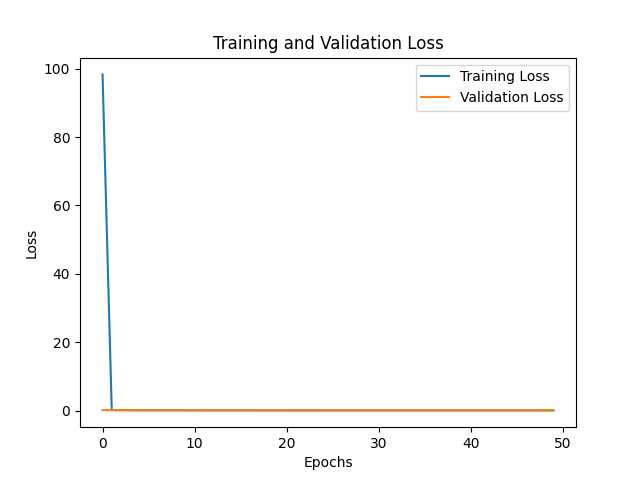

In [110]:
# Plotting the loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

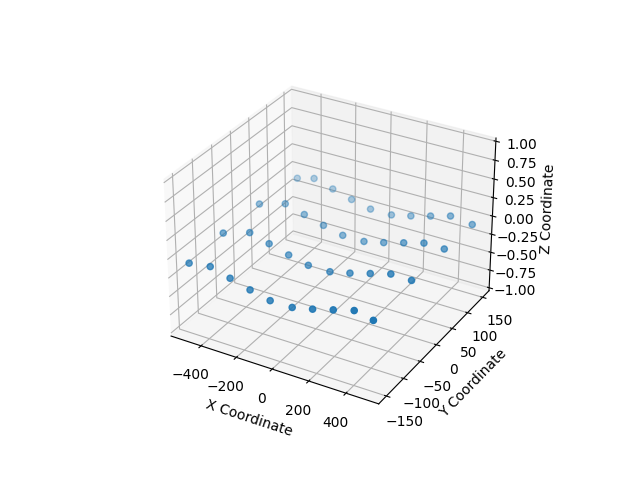

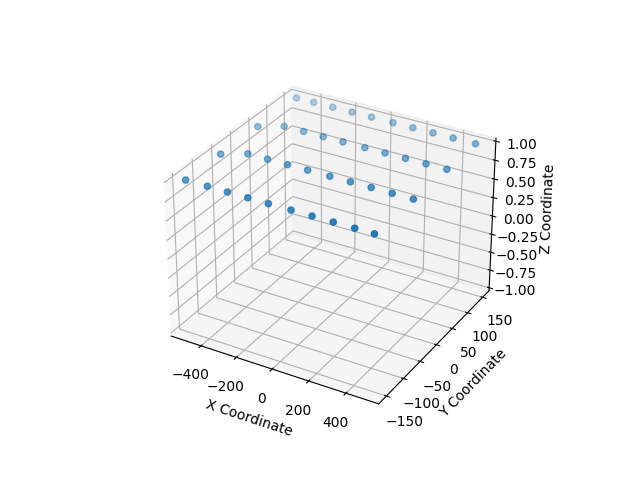

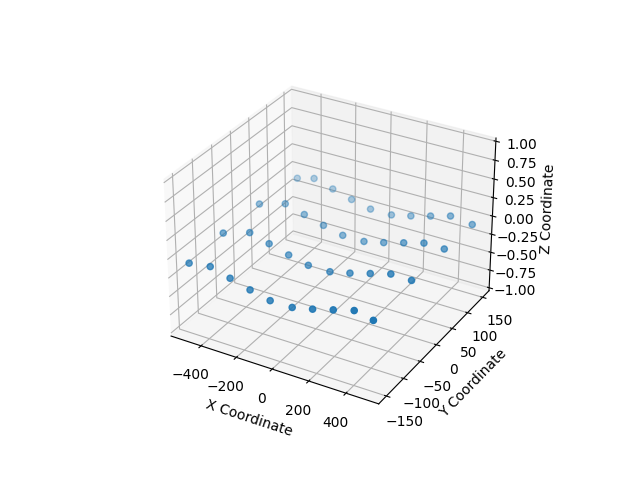

In [111]:
phi_f = sdof_model.get_layer('vector2scalar_f').weights[0].numpy().T
phi_x = sdof_model.get_layer('vector2scalar_x').weights[0].numpy().T
phi_x_T = sdof_model.get_layer('scalar2vector_x').weights[0].numpy().T

coordinates = np.array([data_dicts[node_id]['coordinates'] for node_id in node_ids])

# Make sure interactive plotting is enabled
%matplotlib widget


# Create a 3D scatter plot
fig_phi_x = plt.figure()
ax_phi_x = fig_phi_x.add_subplot(111, projection='3d')
ax_phi_x.scatter(coordinates[:, 0], coordinates[:, 1], phi_x.flatten())
ax_phi_x.set_zlim([-1,1])
# Set labels (optional)
ax_phi_x.set_xlabel('X Coordinate')
ax_phi_x.set_ylabel('Y Coordinate')
ax_phi_x.set_zlabel('Z Coordinate')
plt.show()


# Create a 3D scatter plot
fig_phi_x = plt.figure()
ax_phi_x = fig_phi_x.add_subplot(111, projection='3d')
ax_phi_x.scatter(coordinates[:, 0], coordinates[:, 1], phi_f.flatten())
ax_phi_x.set_zlim([-1,1])
# Set labels (optional)
ax_phi_x.set_xlabel('X Coordinate')
ax_phi_x.set_ylabel('Y Coordinate')
ax_phi_x.set_zlabel('Z Coordinate')
plt.show()

# Create a 3D scatter plot
fig_phi_x = plt.figure()
ax_phi_x = fig_phi_x.add_subplot(111, projection='3d')
ax_phi_x.scatter(coordinates[:, 0], coordinates[:, 1], phi_x_T.flatten())
ax_phi_x.set_zlim([-1,1])
# Set labels (optional)
ax_phi_x.set_xlabel('X Coordinate')
ax_phi_x.set_ylabel('Y Coordinate')
ax_phi_x.set_zlabel('Z Coordinate')
plt.show()


# Predictions as an auto-regressive model

In [106]:
X1_norm_pred = 0*X1_norm
X2_norm_pred = 0*X2_norm

for i in range(X3_norm.shape[0]-1):
    X1_norm_pred[i+1, :], X2_norm_pred[i+1, :] = sdof_model.predict([X1_norm_pred[i, :].reshape((1,-1)), X2_norm_pred[i, :].reshape((1,-1)), X3_norm[i, :].reshape((1,-1))])

1/1 [==============================] - 0s 46ms/step


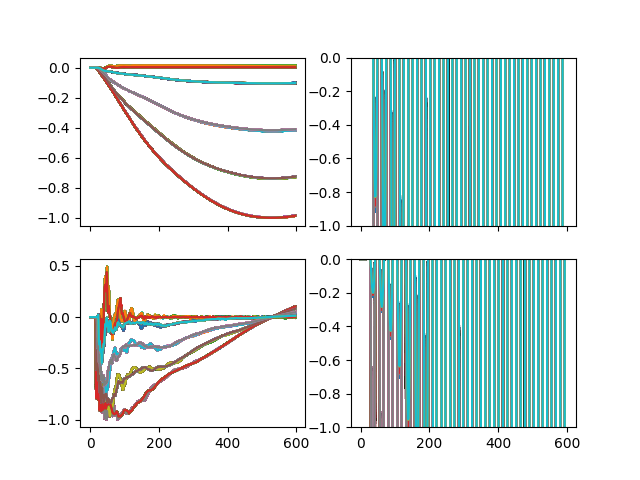

In [107]:
fig, ax = plt.subplots(2, 2, sharex='all')


for node_id in node_ids:
    ax[0,0].plot(X1_norm)
    ax[1,0].plot(X2_norm)
    ax[0,1].plot(X1_norm_pred)
    ax[1,1].plot(X2_norm_pred)
    ax[0,1].set_ylim([-1, 0])
    ax[1,1].set_ylim([-1, 0])
plt.show()

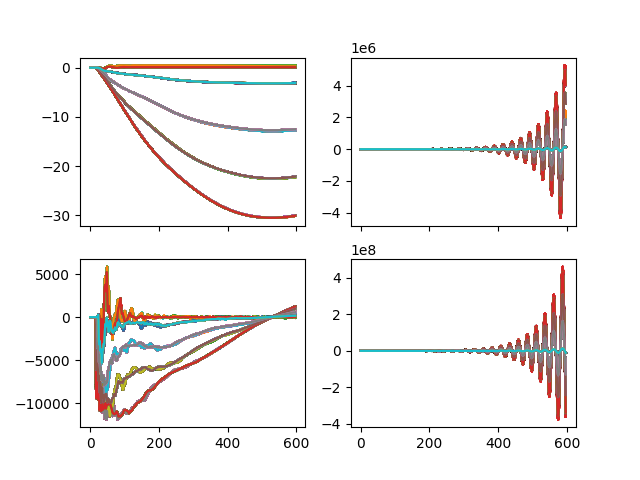

In [108]:
fig, ax = plt.subplots(2, 2, sharex='col')


for node_id in node_ids:
    ax[0,0].plot(X1_norm*scale_X1)
    ax[1,0].plot(X2_norm*scale_X2)
    ax[0,1].plot(X1_norm_pred*scale_X1)
    ax[1,1].plot(X2_norm_pred*scale_X2)
    # ax[0,1].set_ylim([-30, 0])
    # ax[1,1].set_ylim([-1100, 5500])
plt.show()